In [1]:
%pip install -U "leafmap[maplibre]"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import leafmap.foliumap as leafmap
import matplotlib.colors as mcolors
import geopandas as gpd
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

raster_path = r"C:\Users\VINCENT\Downloads\MapLibre Classification\venv\Clip Raster Surabaya\raster_sby1.tif"
dst_crs = 'EPSG:32749'  # WGS 84
output_reprojected_path = r"C:\Users\VINCENT\Downloads\MapLibre Classification\venv\Clip Raster Surabaya\raster_sby1_utm49s.tif"

with rasterio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds,
        resolution=(30,30)
    )

    profile = src.profile
    profile.update(crs=dst_crs, transform=transform, width=width, height=height)

    with rasterio.open(output_reprojected_path, "w", **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )
print(f"Reprojected raster saved at {output_reprojected_path}")

Reprojected raster saved at C:\Users\VINCENT\Downloads\MapLibre Classification\venv\Clip Raster Surabaya\raster_sby1_utm49s.tif


In [9]:
import rasterio.errors
import numpy as np


class_names = {
    0 : "Vegetation",
    1 : "Water",
    2 : "Building",
    3 : "Empty Land",
    4: "Road Network"
}
class_colors = {
    "Vegetation" : '#24ff05',
    "Water"      : '#088fec',
    "Building"   : '#d64926',
    "Empty Land" : '#fffe72',
    "Road Network" : '#9c19ab'
}
try:
    with rasterio.open(output_reprojected_path) as src:
        classification_array = src.read(1)

        pixel_width = src.res[0]
        pixel_height = src.res[1]
        area_per_pixel_sqm = abs(pixel_width * pixel_height)

        raster_crs = src.crs
        print(f"Raster Coordinat System: {raster_crs}")
        print("Pixel Resolution : {pixel_width} * {pixel_height} {raster_crs.linear_units}")

        nodata_value = src.nodata
        if nodata_value is not None:
            classification_array_valid = classification_array[classification_array != nodata_value]
        else:
            classification_array_valid = classification_array

except rasterio.errors.RasterioIOError as e:
    print(f"Error: {e}")
    exit()

unique_classes, counts = np.unique(classification_array_valid, return_counts=True)
pixel_counts= dict(zip(unique_classes, counts))
print("\nNumber of Pixels per Class Value: ")
print(pixel_counts)

area_by_class_sqm = {}
for class_value, pixel_counts in pixel_counts.items():
    if class_value in class_names:
        area_sqm = pixel_counts * area_per_pixel_sqm
        area_by_class_sqm[class_names[class_value]] = area_sqm

    elif class_value == nodata_value:
        print(f"Ignore NoData pixels : {nodata_value}")
    else:
        print(f"WARNING: Class Value '{class_value}' not found in 'class_names'")


Raster Coordinat System: EPSG:32749
Pixel Resolution : {pixel_width} * {pixel_height} {raster_crs.linear_units}

Number of Pixels per Class Value: 
{np.uint8(0): np.int64(68783), np.uint8(1): np.int64(46628), np.uint8(2): np.int64(130018), np.uint8(3): np.int64(92434), np.uint8(4): np.int64(27045)}


In [10]:
import pandas as pd

df_area = pd.DataFrame(list(area_by_class_sqm.items()), columns=['Class', 'Area (m2)'])
df_area['Class_Value'] = df_area['Class'].map({v: k for k, v in class_names.items()})
df_area = df_area.sort_values(by='Class_Value').drop('Class_Value', axis=1)
total_area_sqm = df_area['Area (m2)'].sum()
df_area['Percentage (%)'] = (df_area['Area (m2)'] / total_area_sqm) * 100
df_area['Area (Ha)'] = df_area['Area (m2)']/10000
df_area['Area (km2)'] = df_area['Area (m2)']/1000000

print(f"\nResults of Calculation of Area and Percentage of Land Cover: ")
print(df_area.round(2))


Results of Calculation of Area and Percentage of Land Cover: 
          Class    Area (m2)  Percentage (%)  Area (Ha)  Area (km2)
0    Vegetation   61904700.0           18.85    6190.47       61.90
1         Water   41965200.0           12.78    4196.52       41.97
2      Building  117016200.0           35.63   11701.62      117.02
3    Empty Land   83190600.0           25.33    8319.06       83.19
4  Road Network   24340500.0            7.41    2434.05       24.34


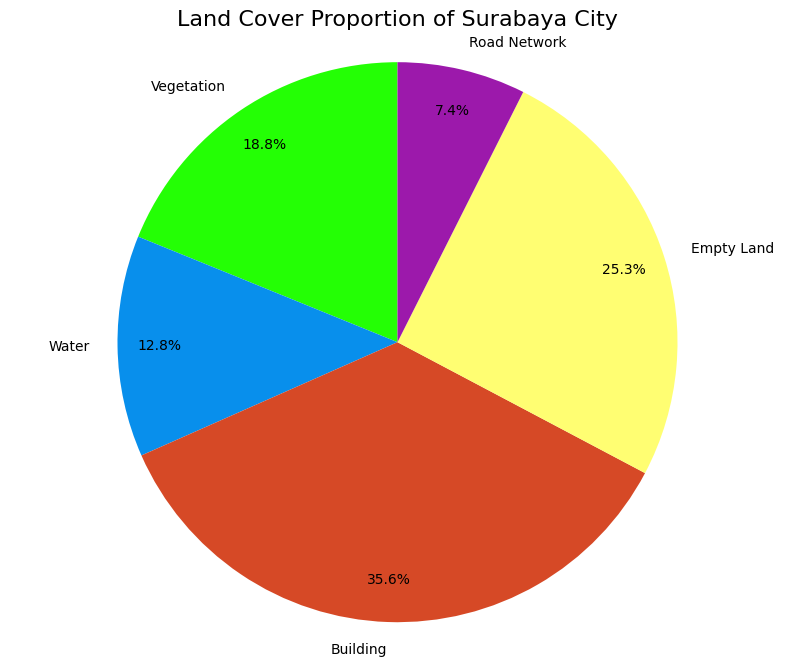

<Figure size 640x480 with 0 Axes>

In [13]:
plot_colors = [class_colors[c] for c in df_area['Class']]

plt.figure(figsize=(10,8))
plt.pie(
    df_area['Percentage (%)'],
    labels=df_area['Class'],
    autopct= '%1.1f%%',
    colors= plot_colors,
    startangle= 90,
    pctdistance= 0.85,
    textprops= {'fontsize' : 10} 
)
plt.title('Land Cover Proportion of Surabaya City', fontsize= 16)
plt.axis('equal')
plt.show()
plt.savefig(r"C:\Users\VINCENT\Downloads\MapLibre Classification\venv\Clip Raster Surabaya\Pie_Chart_SBY.png", dpi=300, bbox_inches= 'tight')



In [ ]:
m = leafmap.Map(
    zoom_control = True,
    draw_control = True,
    scale_control = True,
    attribution_control = True
)
m.add_basemap("OpenTopoMap")
m.add_basemap("CartoDB.DarkMatter")
m.add_basemap("Esri.WorldImagery")
raster_layer =output_reprojected_path
shp_path = r"C:\Users\VINCENT\OneDrive\문서\Latihan mapping\KOTA SURABAYA (1)\KOTA SURABAYA\ADMINISTRASIDESA_AR_25K.shp"
gdf = gpd.read_file(shp_path)
m.add_gdf(
    gdf,
    layer_name= "Batas Administrasi",
    style={
        "color" : "black",
        "weight" : 0.5,
        "fillOpacity" : 0.0
    }
)
gdf
colors = ['#24ff05','#088fec','#d64926','#fffe72', '#9c19ab']
cmap_custom = mcolors.ListedColormap(colors)
m.add_raster(
    raster_layer,
    cmap = cmap_custom,
    opacity= 0.4,
    layer_name= "Land Cover",
    add_colorbar = True
)
m.add_legend(
    title= "Land Cover Classification of Surabaya, 2024",
    legend_dict= {
        "Vegetation" : '#24ff05',
        "Water"      : '#088fec',
        "Building"   : '#d64926',
        "Empty Land" : '#fffe72',
        "Road Network" : '#9c19ab'
    }
)
m


In [25]:
output_html = r"C:\Users\VINCENT\Downloads\MapLibre Classification\venv\Surabaya_LandCover_Map.html"
m.to_html(output_html, title= "Surabaya City Land Cover Classification Map, 2024")